In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS

In [28]:
objname = '9'
nrow = 9

In [29]:
hdus = fits.open(objname+'_drz.fits')
primary = hdus[0].data  # Primary (NULL) header data unit
img = hdus[1].data      # Intensity data
err = hdus[2].data      # Error per pixel
dq = hdus[3].data       # Data quality per pixel

In [36]:
print("Shape: ",img.shape)  # Print the shape of img
print("Min: ",img.min())  # Call the min() method on the img object.
print("Max: ",img.max())
print("Log max: ",np.log(img.max()))
print(hdus[1].data[2000:4300,1000:3300].min())
print(hdus[1].data[2000:4300,1000:3300].max())

Shape:  (4387, 4125)
Min:  -82597384.0
Max:  116893150.0
Log max:  18.57677
-82597384.0
15468773.0


### Plot the FITS file image, cropped:

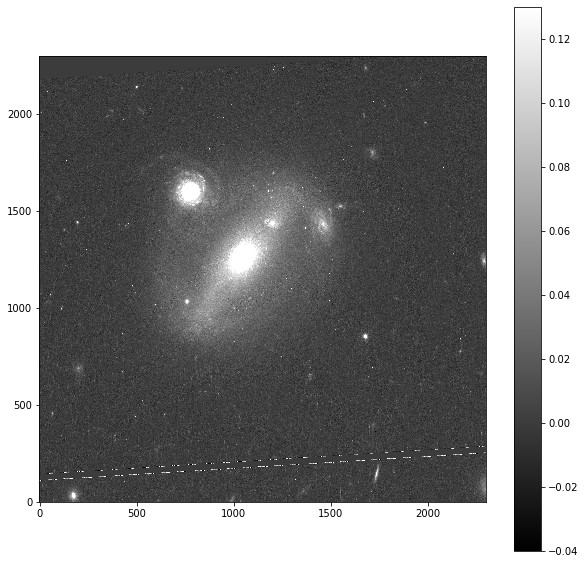

In [5]:
img_data = hdus[1].data[2000:4300,1000:3300]
plt.figure(figsize=(10,10))
plt.imshow(img_data,vmin = -0.04, vmax = 0.13 , origin = 'lower',cmap='gray')
plt.colorbar()

#### Since most of the sum is in the background region there is a lot of noise and cosmic-ray contamination.

### Read in excel sheet Apertures.xlsx and extract the xy values for the foreground galaxy, background galaxy, overlap region:

In [268]:
from openpyxl import load_workbook
from openpyxl import Workbook
workbook = load_workbook(filename="Apertures.xlsx")
workbook.sheetnames
sheet = workbook.active

In [10]:
def print_rows():
    for row in sheet.iter_rows(values_only=True):
        print(row)
def print_cols():
    for col in sheet.iter_cols(values_only=True):
        print(col)

### Print the value of a particular cell:

In [115]:
#sheet["I15"].value

### Print the values of an entire row:
(note--same code for columns just replace "row" with "col")

In [116]:
#for row_cells in sheet.iter_rows(min_row=6, max_row=6):
#    for cell in row_cells:
#        print(cell.value)  

### Fetch the xy aperture coordinates of specified columns (D,E,F,etc) given a particular row:

In [269]:
for row in range(nrow+1,nrow+2):
    # get the cell value
    FG_x = sheet['D' + str(row)].value
    FG_y = sheet['E' + str(row)].value
    BG_x = sheet['F' + str(row)].value
    BG_y = sheet['G' + str(row)].value
    ov_x = sheet['H' + str(row)].value
    ov_y = sheet['I' + str(row)].value
    sky_x = sheet['J' + str(row)].value
    sky_y = sheet['K' + str(row)].value
    
print(FG_x)

2027


### Sum the intensity in the specified aperture and print the intensity profiles:

In [273]:
profile_FG = img[FG_x:FG_x+1,FG_y:FG_y+1].sum()
profile_BG = img[BG_x:BG_x+1,BG_y:BG_y+1].sum()
profile_ov = img[ov_x:ov_x+1,ov_y:ov_y+1].sum()
profile_sky = img[sky_x:sky_x+1,sky_y:sky_y+1].sum()

print("Foreground = ",profile_FG)
print("Background = ",profile_BG)
print("Overlap = ",profile_ov)
print("Sky = ",profile_sky)

Foreground =  -0.011741908
Background =  0.04474153
Overlap =  -0.04768076
Sky =  0.18169317


## Calculate the transmission:

In [235]:
T = (profile_ov - profile_FG)/profile_BG
print("Transmission = ",T)

Transmission =  4.844881


#### The transmission value aka the optical depth. Closer to 0 means dusty, while higher values means transparent. 

### Save transmission value to the excel sheet in a blank column:

In [328]:
#for row in range(nrow+1,nrow+2):
#    sheet['L'+str(row)] = T
#    workbook.save('Apertures.xlsx')

### Calculate statistics (standard deviation)

In [281]:
import numpy as np

profile_FG1 = img[FG_x:FG_x+10,FG_y:FG_y+10]
profile_BG1 = img[BG_x:BG_x+10,BG_y:BG_y+10]
profile_ov1 = img[ov_x:ov_x+10,ov_y:ov_y+10]
profile_sky1 = img[sky_x:sky_x+10,sky_y:sky_y+10]

print("Foreground = ")
print(profile_FG1.std())
print("Background = ")
print(profile_BG1.std())
print("Overlap = ")
print(profile_ov1.std())
print("Sky = ")
print(profile_sky1.std())

Foreground = 
0.007911816
Background = 
0.009197443
Overlap = 
0.0062551554
Sky = 
0.0073675266


In [38]:
from astropy.convolution import convolve,Gaussian2DKernel
fwhm = 5
smoothed = convolve(img, Gaussian2DKernel(x_stddev=fwhm/2.35))
import aplpy

smoothed_figure = aplpy.FITSFigure(fits.PrimaryHDU(data=smoothed,header=header))
smoothed_figure.show_grayscale()
 
# Alternatively, but less flexible, display and smooth simultaneously:
fig = aplpy.FITSFigure('filename.fits')
fig.show_grayscale(smooth=fwhm/2.35)

from astropy import wcs
w = wcs.WCS(header)
# Determine the approximate pixel scale, assuming square pixels [you are likely to get an important warning here]
# Also, this may require the development version of astropy
cd = wcs.utils.celestial_pixel_scale(w)
slice = data[50,:] # grab a slice along one direction
offsets = np.arange(slice) * cd
 
# then, print to file:
with open('outfile','w') as f:
    for position,value in zip(offsets,slice):
        f.write("{0:10f} {1:10f}\n".format(position,value))

ImportError: cannot import name 'get_parameters' from 'astropy.utils.misc' (/Users/alicejacques/anaconda3/lib/python3.7/site-packages/astropy/utils/misc.py)